In [140]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# Setting params for matplotlib figures
plt.rcParams.update({"figure.figsize": (6, 6),
                      "axes.facecolor": "white",
                      "axes.edgecolor": "black"})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sb.color_palette('colorblind'))
font = {'family': 'sans-serif',
         'weight': 'normal',
         'size': 14}
plt.rc('font', **font)

file_path = 'Synthetic_ICU_Dataset_CGPT.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Patient_ID'])

df.head()

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10423 entries, 0 to 10422
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Admission Hospital         10423 non-null  object
 1   Admission Unit             10423 non-null  object
 2   Admission Date             10423 non-null  object
 3   Admission Decision Time    10423 non-null  object
 4   Admission Time             10423 non-null  object
 5   Discharge Date             10423 non-null  object
 6   Survived                   10423 non-null  int64 
 7   Diagnosis                  10423 non-null  object
 8   Length of Stay             10423 non-null  int64 
 9   Cardiovascular Support     10423 non-null  int64 
 10  Dialysis Support           10423 non-null  int64 
 11  Invasive Ventilation       10423 non-null  int64 
 12  Nutrition                  10423 non-null  int64 
 13  Age                        10423 non-null  int64 
 14  Gender

In [141]:
categorical_columns = ['Admission Hospital', 'Admission Unit', 'Diagnosis', 'Gender']
for column in categorical_columns:
    df[column] = df[column].astype('category')

category_names = {col: df[col].cat.categories for col in categorical_columns}
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

print(df.head())


  Admission Date Admission Decision Time Admission Time Discharge Date  \
0     2022-07-19                   10:11          12:11     02/08/2022   
1     2022-08-22                   07:48          09:48     24/08/2022   
2     2022-01-26                   16:50          17:50     05/02/2022   
3     2022-02-11                   19:09          22:09     15/02/2022   
4     2022-03-02                   00:23          02:23     06/03/2022   

   Survived  Length of Stay  Cardiovascular Support  Dialysis Support  \
0         0              14                       1                 0   
1         1               2                       0                 0   
2         0              10                       1                 0   
3         1               4                       0                 0   
4         1               4                       0                 0   

   Invasive Ventilation  Nutrition  ...  Diagnosis_Sepsis  \
0                     0          1  ...             Fal

In [142]:
from datetime import datetime, timedelta

df['Admission Date'] = pd.to_datetime(df['Admission Date'], format='%Y-%m-%d')
df['Admission Decision Time'] = pd.to_datetime(df['Admission Decision Time'], format='%H:%M').dt.time
df['Admission Time'] = pd.to_datetime(df['Admission Time'], format='%H:%M').dt.time
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], format='%d/%m/%Y')

def calculate_wait_time(row):
    decision_datetime = datetime.combine(row['Admission Date'], row['Admission Decision Time'])
    admission_datetime = datetime.combine(row['Admission Date'], row['Admission Time'])

    if admission_datetime < decision_datetime:
        admission_datetime += timedelta(days=1)

    return (admission_datetime - decision_datetime).total_seconds() / 3600

df['Wait Time (hrs)'] = df.apply(calculate_wait_time, axis=1)

df['Month'] = df['Admission Date'].dt.month
season_mapping = {
    11: 'Winter', 12: 'Winter', 1: 'Winter',
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn'
}

df['Season'] = df['Month'].map(season_mapping)

df.to_csv('Synthetic_ICU_Dataset_CGPT2.csv', index=False)

print(df[['Admission Date', 'Month', 'Season', 'Wait Time (hrs)']].head())

  Admission Date  Month  Season  Wait Time (hrs)
0     2022-07-19      7  Summer              2.0
1     2022-08-22      8  Autumn              2.0
2     2022-01-26      1  Winter              1.0
3     2022-02-11      2  Spring              3.0
4     2022-03-02      3  Spring              2.0


In [143]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df['Season'] = pd.Categorical(df['Season'], categories=season_order, ordered=True)
season_tally = df['Season'].value_counts().reindex(season_order)

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['Month Name'] = df['Month'].map(month_mapping)  
df['Month Name'] = pd.Categorical(df['Month Name'], categories=month_order, ordered=True)
month_tally = df['Month Name'].value_counts().reindex(month_order)

In [144]:
from pycaret.regression import *

reg = setup(df, target='Length of Stay', fold = 5)
best_model = compare_models()

,Description,Value
0,Session id,4772
1,Target,Length of Stay
2,Target type,Regression
3,Original data shape,"(10423, 78)"
4,Transformed data shape,"(10423, 96)"
5,Transformed train set shape,"(7296, 96)"
6,Transformed test set shape,"(3127, 96)"
7,Numeric features,19
8,Date features,2
9,Categorical features,4


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1863,0.1022,0.3194,0.9915,0.0584,0.0518,0.3940
br,Bayesian Ridge,0.1865,0.1022,0.3195,0.9915,0.0584,0.0519,0.1680
knn,K Neighbors Regressor,1.1746,2.9584,1.7171,0.7527,0.2965,0.3776,0.1320
lightgbm,Light Gradient Boosting Machine,1.1279,3.8286,1.9539,0.6800,0.2909,0.3394,0.2360
ridge,Ridge Regression,2.2908,8.8932,2.9814,0.2571,0.5011,0.7792,0.0960
gbr,Gradient Boosting Regressor,2.2302,8.9435,2.9879,0.2525,0.4927,0.7529,0.5180
rf,Random Forest Regressor,2.4592,11.4791,3.3868,0.0405,0.5468,0.8010,1.6460
en,Elastic Net,2.6531,11.9719,3.4598,-0.0002,0.5768,0.9584,0.1020
llar,Lasso Least Angle Regression,2.6533,11.9731,3.4600,-0.0003,0.5768,0.9584,0.0920
lasso,Lasso Regression,2.6533,11.9731,3.4600,-0.0003,0.5768,0.9584,0.2580


,Description,Value
0,Session id,7269
1,Target,Length of Stay
2,Target type,Regression
3,Original data shape,"(10423, 78)"
4,Transformed data shape,"(10423, 96)"
5,Transformed train set shape,"(7296, 96)"
6,Transformed test set shape,"(3127, 96)"
7,Numeric features,19
8,Date features,2
9,Categorical features,4


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1863,0.1012,0.3178,0.9917,0.0575,0.0509,0.1220
br,Bayesian Ridge,0.1865,0.1013,0.3179,0.9917,0.0575,0.0510,0.1500
knn,K Neighbors Regressor,1.1855,3.1080,1.7555,0.7489,0.2972,0.3736,0.1280
lightgbm,Light Gradient Boosting Machine,1.1639,3.9506,1.9800,0.6809,0.2965,0.3539,0.2420
ridge,Ridge Regression,2.2678,8.7750,2.9606,0.2874,0.4923,0.7560,0.0940
omp,Orthogonal Matching Pursuit,1.8657,9.1763,2.4790,0.2242,0.4051,0.6258,0.0880
gbr,Gradient Boosting Regressor,2.3254,9.7920,3.1258,0.2045,0.5067,0.7697,0.5000
rf,Random Forest Regressor,2.4568,11.6397,3.4082,0.0557,0.5439,0.7914,1.5880
en,Elastic Net,2.6885,12.3198,3.5087,-0.0011,0.5771,0.9547,0.1040
lasso,Lasso Regression,2.6891,12.3246,3.5094,-0.0015,0.5772,0.9548,0.1020


The selected model does not have feature importances. Let's try a dt model.


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0329,20.6438,4.5435,-0.5381,0.6989,0.9808
1,2.9397,18.2748,4.2749,-0.5471,0.6791,0.8753
2,3.3722,21.8053,4.6696,-0.7234,0.7399,0.9640
3,2.8787,17.7903,4.2179,-0.5337,0.6825,0.8908
4,2.9088,17.5586,4.1903,-0.4579,0.6807,0.9354
Mean,3.0265,19.2146,4.3792,-0.5600,0.6962,0.9293
Std,0.1804,1.6976,0.1918,0.0877,0.0230,0.0407


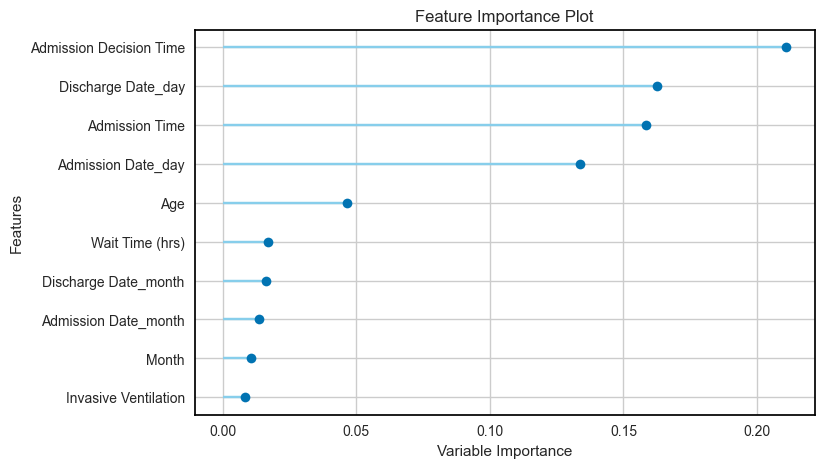

In [145]:
reg = setup(data=df, target='Length of Stay', fold=5)

best_model = compare_models()

if hasattr(best_model, 'feature_importances_'):
    plot_model(best_model, plot='feature')
else:
    print("The selected model does not have feature importances. Let's try a dt model.")
    dt_model = create_model('dt')
    plot_model(dt_model, plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.1661,17.4117,4.1727,-0.2973,0.6638,1.0776
1,3.0275,16.0067,4.0008,-0.3551,0.6309,0.9691
2,3.1333,16.9751,4.1201,-0.3417,0.6384,0.9409
3,2.9544,15.1017,3.8861,-0.3019,0.6289,0.9927
4,3.0754,16.0632,4.0079,-0.3338,0.6508,1.0341
Mean,3.0713,16.3117,4.0375,-0.3259,0.6426,1.0029
Std,0.0754,0.8086,0.1003,0.0226,0.0131,0.0482


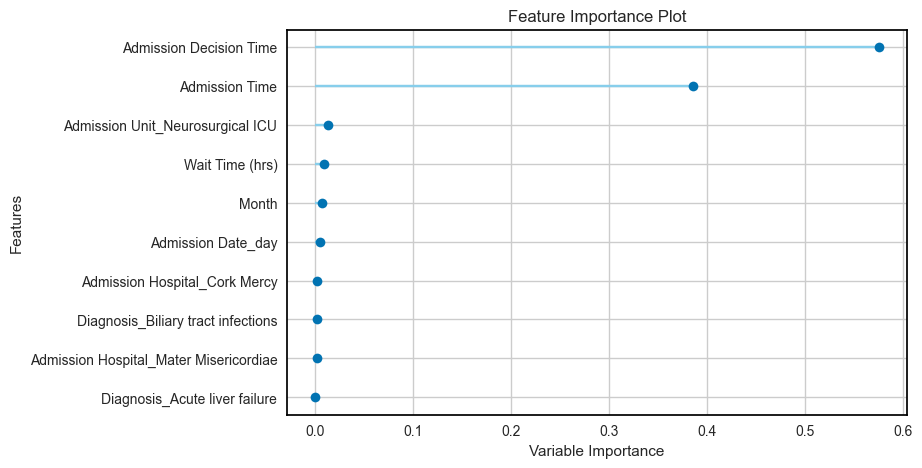

In [146]:
dt_model = create_model('dt', max_depth=5)
plot_model(dt_model, plot='feature')
params = dt_model.get_params()

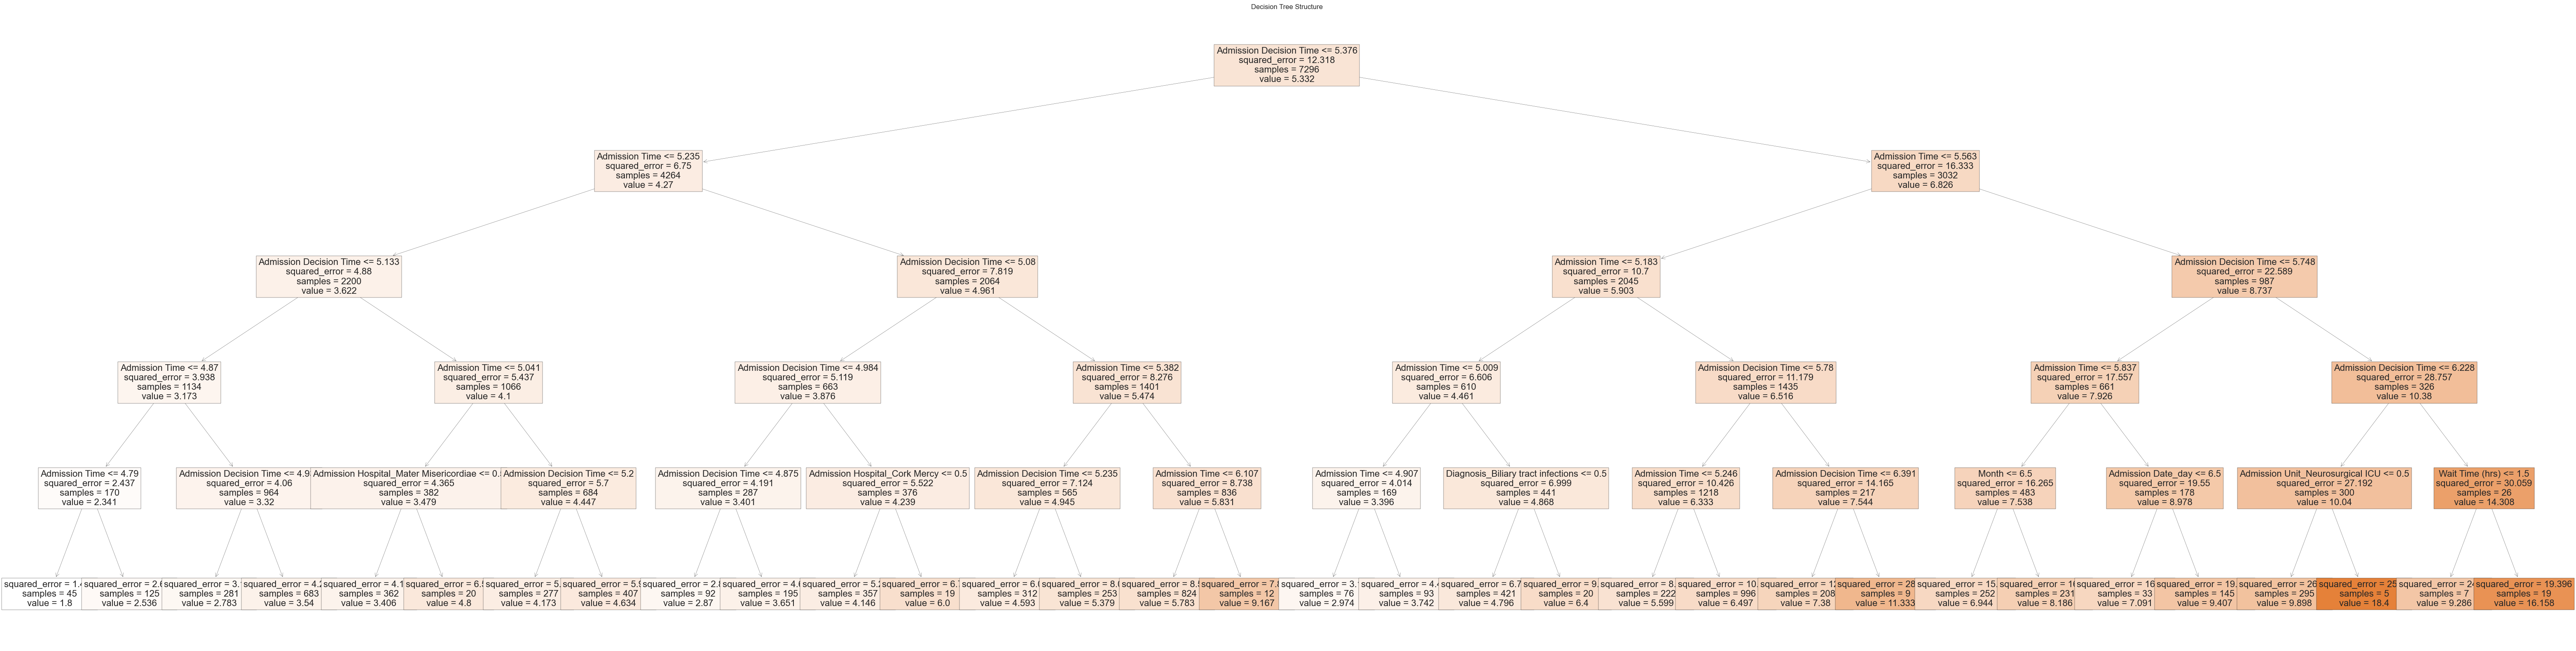

In [147]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

sklearn_dt = dt_model


plt.figure(figsize=(80, 20)) 
plot_tree(
    sklearn_dt,
    filled=True,
    feature_names=dt_model.feature_names_in_,
    max_depth=5,  
    fontsize=16
)
plt.title("Decision Tree Structure")
plt.show()


,Description,Value
0,Session id,2895
1,Target,Length of Stay
2,Target type,Regression
3,Original data shape,"(10423, 51)"
4,Transformed data shape,"(10423, 54)"
5,Transformed train set shape,"(7296, 54)"
6,Transformed test set shape,"(3127, 54)"
7,Numeric features,19
8,Categorical features,1
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7274,12.9633,3.6005,-0.0554,0.5922,1.0060
1,2.6635,12.0889,3.4769,-0.0265,0.5777,0.9565
2,2.6865,12.2677,3.5025,-0.0461,0.5787,0.9559
3,2.6904,12.1766,3.4895,-0.0044,0.5812,0.9691
4,2.7826,14.1913,3.7671,-0.0162,0.5855,0.9344
Mean,2.7101,12.7375,3.5673,-0.0297,0.5831,0.9644
Std,0.0416,0.7900,0.1090,0.0188,0.0053,0.0236


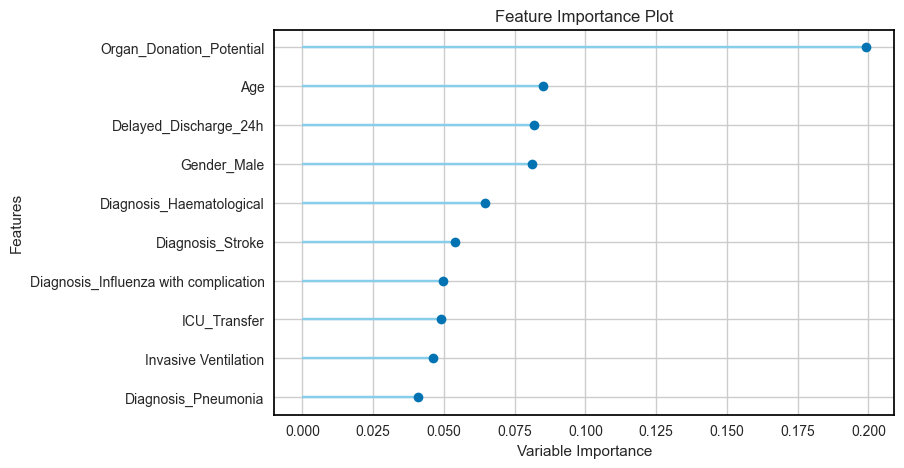

In [148]:
selected_features = ["Length of Stay","Survived","Cardiovascular Support", "Dialysis Support", "Invasive Ventilation", "Nutrition", "Age", "Unplanned_Readmission_48h", "Unplanned_Discharge_Night", "High_Risk_Sepsis", "Unit_Acquired_Infection", "Organ_Donation_Potential", "ICU_Transfer", "Delayed_Discharge_8h", "Delayed_Discharge_24h", "Mortality_Risk", "COVID_Severity", "COVID_Status", "Admission Unit_Cardio ICU", "Admission Unit_General ICU", "Admission Unit_HDU", "Admission Unit_ICU", "Admission Unit_Neurosurgical ICU", "Diagnosis_ARDS", "Diagnosis_Acute kidney injury (AKI)", "Diagnosis_Acute liver failure", "Diagnosis_Acute respiratory failure", "Diagnosis_Biliary tract infections", "Diagnosis_Cardiogenic shock", "Diagnosis_Cerebral edema", "Diagnosis_Haematological", "Diagnosis_Heart failure", "Diagnosis_Influenza with complication", "Diagnosis_Intracranial hemorrhage", "Diagnosis_Metastatic disease", "Diagnosis_Multiple organ failure", "Diagnosis_Pneumonia", "Diagnosis_Pulmonary embolism", "Diagnosis_Sepsis", "Diagnosis_Septic shock", "Diagnosis_Severe asthma", "Diagnosis_Severe diabetic ulcers", "Diagnosis_Shock", "Diagnosis_Stroke", "Diagnosis_Trauma", "Diagnosis_Traumatic Brain Injury (TBI)", "Gender_Female", "Gender_Male", "Wait Time (hrs)", "Month", "Season"]
df_selected = df[selected_features]

reg = setup(data=df_selected, target='Length of Stay', fold=5)

dt_model = create_model('dt', max_depth=5)
plot_model(dt_model, plot='feature')

In [149]:

params = dt_model.get_params()
print(params)

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 2895, 'splitter': 'best'}


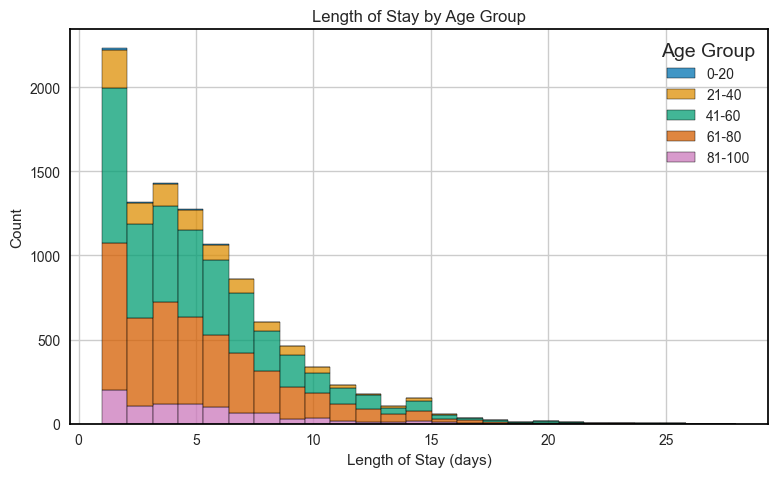

In [150]:
df['Age Group'] = pd.cut(df['Age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20','21-40','41-60','61-80','81-100'])

plt.figure(figsize=(8, 5))
sb.histplot(data=df, x='Length of Stay', hue='Age Group', multiple='stack', bins=25)
plt.title('Length of Stay by Age Group')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


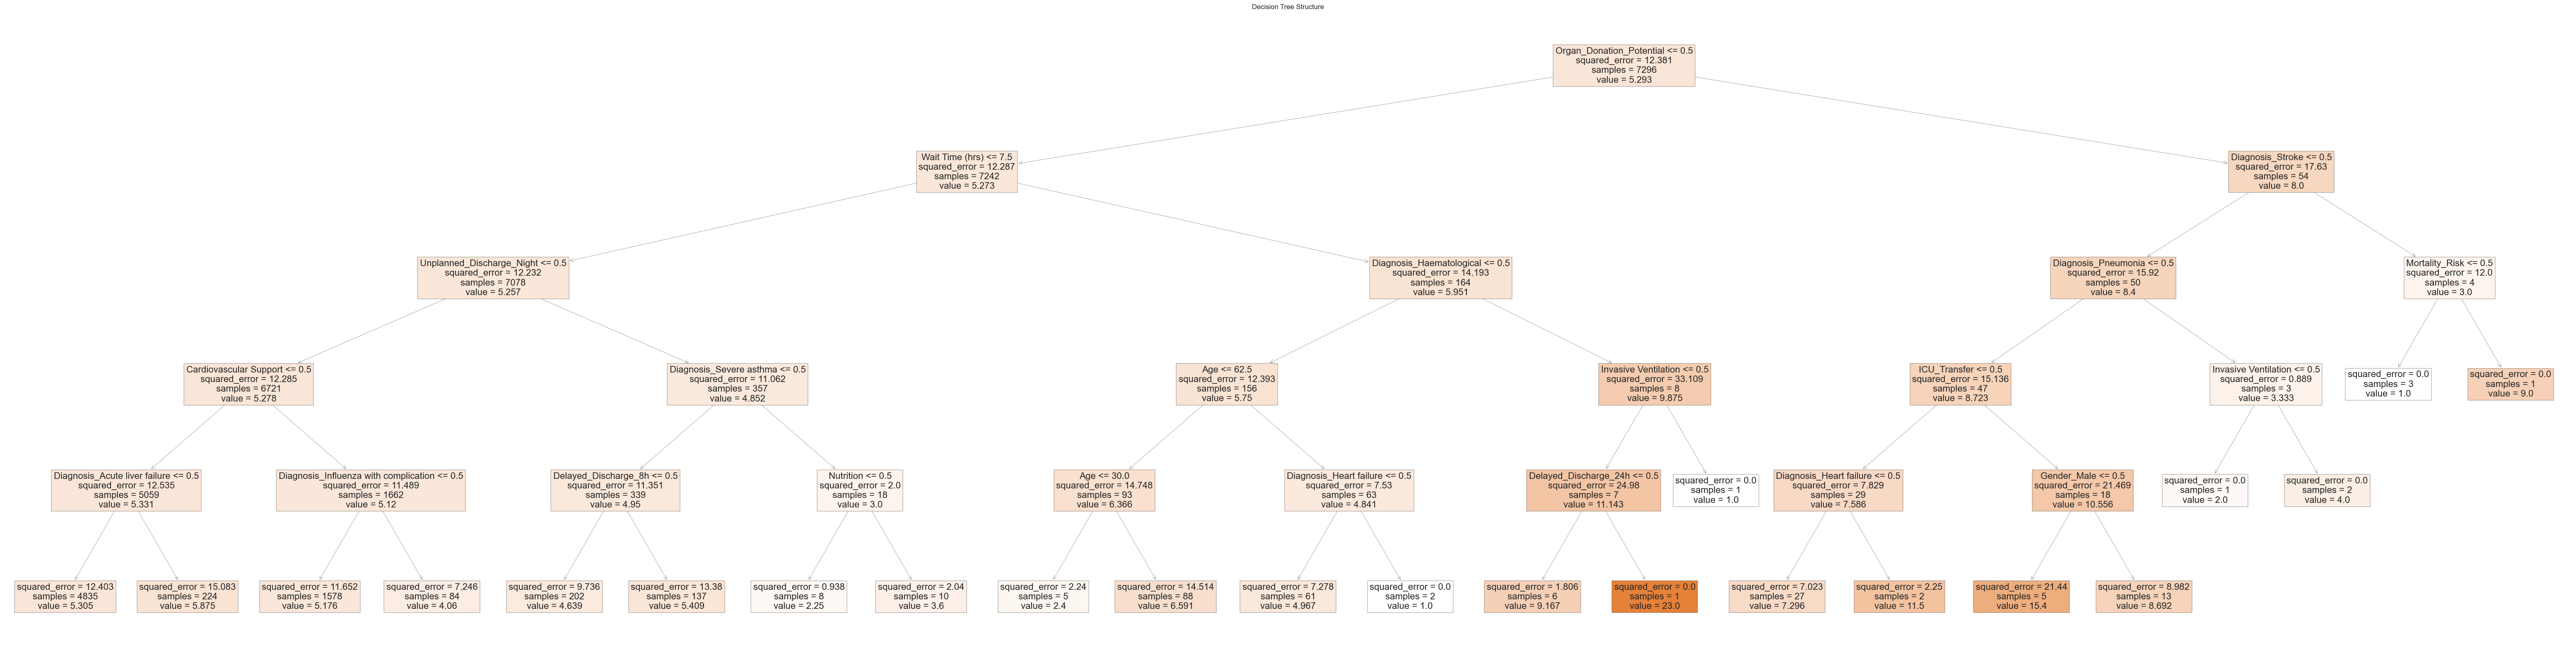

In [151]:
sklearn_dt = dt_model


plt.figure(figsize=(80, 20)) 
plot_tree(
    sklearn_dt,
    filled=True,
    feature_names=dt_model.feature_names_in_,
    max_depth=5,  
    fontsize=16
)
plt.title("Decision Tree Structure")
plt.show()